In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import os
# from matplotlib import pyplot
import matplotlib.pyplot as plt
import shutil
from datetime import datetime
from nrt_wind.wind import read_wind_mag
from nrt_wind.Pre_processing import create_hodogram_realFR_t_minus_24hr
from nrt_wind.DeepFRi_test import cnn_model_fit_60_30
from nrt_wind.Prepare_list import prepare_pre_list
from nrt_wind.Prepare_list import boundary_finding
from nrt_wind.DiFR_test import DiFR

Applying DeepFRi and DiFR models on real solar wind time series and deriving list of FRs with start and end boundaries and geoeffectiveness.

In [6]:
imgPath='./nrt_wind/'

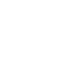

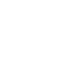

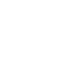

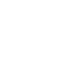

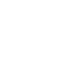

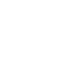

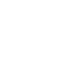

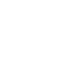

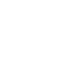

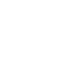

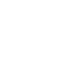

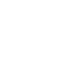

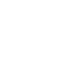

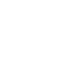

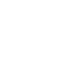

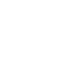

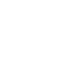

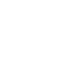

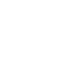

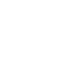

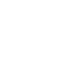

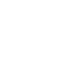

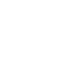

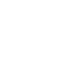

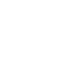

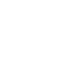

In [7]:
path = os.path.join(imgPath, 'bx_by')
isFile = os.path.isdir(path)
if isFile==True:
    shutil.rmtree(path)
os.makedirs(path)
path = os.path.join(imgPath, 'bx_bz')
isFile = os.path.isdir(path)
if isFile==True:
    shutil.rmtree(path)
os.makedirs(path)
path = os.path.join(imgPath, 'bz_by')
isFile = os.path.isdir(path)
if isFile==True:
    shutil.rmtree(path)
os.makedirs(path)

path = os.path.join(imgPath, 'concat')
isFile = os.path.isdir(path)
if isFile==True:
    shutil.rmtree(path)
os.makedirs(path)
#####........................Start and end time during which users would like to search for FRs..........................
st='2023-12-16 00:00:00'
et='2023-12-16 01:00:00'

#####........................Pre-processing and preparing hodograms............................................
create_hodogram_realFR_t_minus_24hr(st,et,imgPath)


26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1


2023-

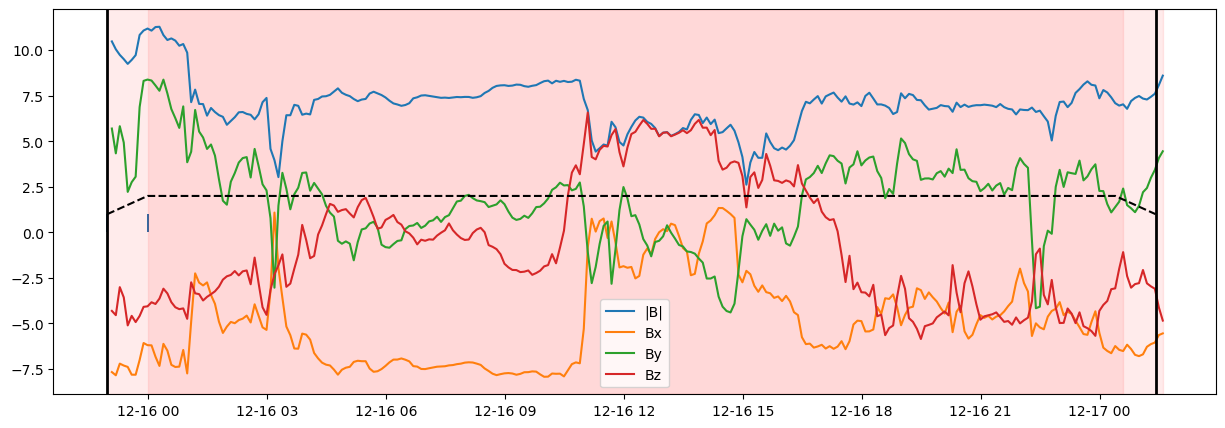

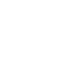

In [8]:
#####........................Applying DeepFRi model............................................
input='nrt_result60_30_test.txt'
file=imgPath+input
cnn_model_fit_60_30(imgPath,file)

#####........................Preparing List1 and List2............................................
list1='List1.txt'
prepare_pre_list(imgPath,input,list1)
outfile= 'List2.txt'
if os.path.getsize(imgPath+list1) == 0:
        print('no FRs')
else:  
    df= pd.read_csv(imgPath+list1, sep=" ", header=None)
    list2= open(imgPath+outfile, 'w')
    for i in df.index:
        tstart=df[0][i]+' '+df[1][i]
        tend=df[2][i]+' '+df[3][i]
        boundary_finding(imgPath,input,tstart,tend,list2)
    list2.close() 

#####........................Applying DiFR model and create the Final list............................................
finallist='Final_list.txt'
DiFR(imgPath,outfile,finallist)

Plotting FRs embeded in solar wind data.

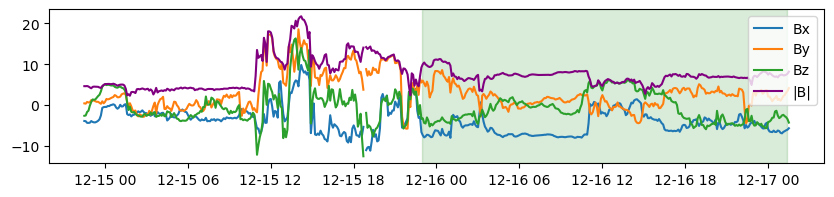

In [10]:
st='2023-12-16 00:00:00'
et='2023-12-16 01:00:00'
i = 0
npoint=256
window_duration=24 #in hours
l=int(np.round(window_duration*60./npoint)) 

tts=pd.to_datetime((datetime.strptime(str(st), "%Y-%m-%d %H:%M:%S")-datetime(1970, 1, 1, 0, 0)).total_seconds()-l*npoint*60.,unit='s')
tte=pd.to_datetime((datetime.strptime(str(st), "%Y-%m-%d %H:%M:%S")-datetime(1970, 1, 1, 0, 0)).total_seconds()+l*npoint*60.,unit='s')

df= read_wind_mag( tts,tte)
bxn=df.Bx.rolling(window=l,step=l).mean()
byn=df.By.rolling(window=l,step=l).mean()
bzn=df.Bz.rolling(window=l,step=l).mean()  
plt.figure(figsize=(10, 2))
plt.plot(bxn,label='Bx')
plt.plot(byn,label='By')
plt.plot(bzn,label='Bz')
plt.plot(np.sqrt(bxn*bxn+byn*byn+bzn*bzn),label='|B|',color='purple')
plt.legend()
if os.path.getsize(imgPath+'List2.txt') != 0:
     df_list2= pd.read_csv(imgPath+'List2.txt', sep=" ", header=None)
     FR_s_l2=pd.to_datetime(df_list2[0][i]+' '+df_list2[1][i])
     FR_e_l2=pd.to_datetime(df_list2[2][i]+' '+df_list2[3][i])
     plt.axvspan(FR_s_l2,FR_e_l2, ymin=0, ymax=1, alpha=0.05, color='green')
if os.path.getsize(imgPath+'Final_list.txt') != 0:
     df_final= pd.read_csv(imgPath+'Final_list.txt', sep=" ", header=None)
     FR_s=pd.to_datetime(df_final[0][i]+' '+df_final[1][i])
     FR_e=pd.to_datetime(df_final[2][i]+' '+df_final[3][i])
     ##TODO:  Should there be a column '7'?? 
     ## looks like it might be equivalent to the current column '4'- AAN
     # if df_final[7][i]!=0:
     #      plt.axvspan(FR_s,FR_e, ymin=0, ymax=1, alpha=0.1, color='green')
     plt.axvspan(FR_s,FR_e, ymin=0, ymax=1, alpha=0.1, color='green')


This is what I see in df_final:

In [11]:
df_final

,0,1,2,3,4,5
0,2023-12-15,22:58:33,2023-12-17,01:24:33,0,NaN


Below is from an older run:

In [17]:
df_final

,0,1,2,3,4,5,6,7,8
0,2023-12-16,02:01:33,2023-12-17,04:27:33,NaN,-6.654476,0.587692,0,NaN


In [8]:
list2

<_io.TextIOWrapper name='./nrt_wind/List2.txt' mode='w' encoding='UTF-8'>